In [105]:
# Import libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import joblib
from pathlib import Path 
import matplotlib.pyplot as plt


In [106]:
PATH = Path("../data/metadata.csv")
df = pd.read_csv(PATH)
df

FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\metadata.csv'

In [ ]:
#df.columns

# This is the columns we are removing for training of the tree

colDrop = list(df.columns)
colDrop
columns2keep = ["age","diagnostic",'itch',"hurt","bleed","elevation"]
for i in columns2keep:
    colDrop.remove(i)

In [ ]:
df = df.drop(columns=colDrop)
df

,age,diagnostic,itch,hurt,bleed,elevation
0,75,SEK,False,FALSE,FALSE,True
1,64,BCC,True,TRUE,TRUE,True
2,41,ACK,False,FALSE,FALSE,False
3,57,ACK,True,FALSE,FALSE,False
4,85,SCC,True,FALSE,FALSE,True
...,...,...,...,...,...,...
112,75,BCC,True,FALSE,TRUE,True
113,73,ACK,True,FALSE,FALSE,True
114,56,BCC,True,FALSE,FALSE,True
115,57,BCC,True,FALSE,FALSE,False


In [ ]:
# Next blox or just for cleaning up the data

In [ ]:
df = df[df["hurt"] != "UNK"]
df["hurt"] = ~df["hurt"].str.contains("FALSE", na=False)

C:\Users\hassa\AppData\Local\Temp\ipykernel_30064\217399709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hurt"] = ~df["hurt"].str.contains("FALSE", na=False)


In [ ]:
df = df[df["bleed"] != "UNK"]
df["bleed"] = ~df["bleed"].str.contains("FALSE", na=False)

In [ ]:
df["elevation"].dropna()

0       True
1       True
2      False
3      False
4       True
       ...  
112     True
113     True
114     True
115    False
116     True
Name: elevation, Length: 116, dtype: bool

In [ ]:
# X is input Y is output
X = df.iloc[:,0:20].drop(columns="diagnostic")
Y = df.iloc[:,1]

In [ ]:
# seperation into test and training data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=1,test_size=0.2)

In [ ]:
rf = RandomForestClassifier(n_estimators=1000,
                            criterion="entropy",
                            min_samples_split=11,
                            max_depth=15,
                            random_state=17,
                            min_samples_leaf=2)

In [ ]:
# this are the parameters we can tune
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 11,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rf.fit(X_train,Y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2,
                       min_samples_split=11, n_estimators=1000,
                       random_state=17)

In [ ]:
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance_df 

,feature,importance
0,age,0.372916
1,itch,0.266889
4,elevation,0.155188
3,bleed,0.148190
2,hurt,0.056816


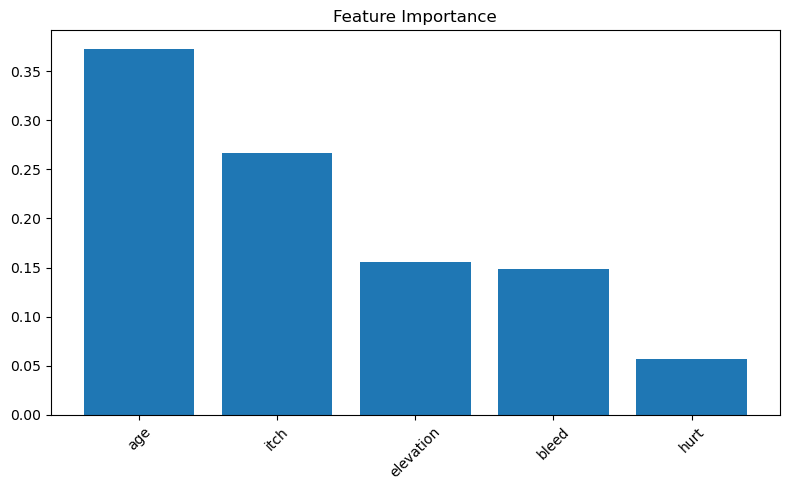

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xticks(rotation=45)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
# These following blox are Giving a Dianosis of how good the algo is

In [ ]:
def second_highest_index(arr):
    arr = np.asarray(arr)
    unique_vals = np.unique(arr)
    if unique_vals.size < 2:
        return None
    second_highest = unique_vals[-2]
    return np.where(arr == second_highest)[0][0]

In [ ]:
predictions = rf.predict(X_test)
probs = rf.predict_proba(X_test)
classes = rf.classes_
real = Y_test.to_numpy()

f = 0
fs = 0
for i in range(len(predictions)):
    first_correct = real[i] == predictions[i]
    colorF = "\033[0;34m" if first_correct else "\033[0;31m"

    second_idx = second_highest_index(probs[i])
    second_class = classes[second_idx] if second_idx is not None else None
    second_correct = real[i] == second_class
    colorS = "\033[0;34m" if second_correct else "\033[0;31m"
    colorForS = "\033[0;34m" if second_correct or first_correct else "\033[0;31m"
    f += int(first_correct)
    fs += int(second_correct or first_correct)
    print(
        f"real: {real[i]}, "
        f"pred: {predictions[i]}, "
        f"First guess: {colorF}{first_correct}\033[0m, "
        f"Second guess: {colorS}{second_correct}\033[0m "
        f"First or Second guess: {colorForS}{second_correct or first_correct}\033[0m"
    )
print(f/len(predictions),"   ", fs/len(predictions))

real: NEV, pred: NEV, First guess: True, Second guess: False First or Second guess: True
real: BCC, pred: BCC, First guess: True, Second guess: False First or Second guess: True
real: SEK, pred: SEK, First guess: True, Second guess: False First or Second guess: True
real: NEV, pred: NEV, First guess: True, Second guess: False First or Second guess: True
real: ACK, pred: ACK, First guess: True, Second guess: False First or Second guess: True
real: BCC, pred: ACK, First guess: False, Second guess: True First or Second guess: True
real: BCC, pred: BCC, First guess: True, Second guess: False First or Second guess: True
real: ACK, pred: ACK, First guess: True, Second guess: False First or Second guess: True
real: SCC, pred: BCC, First guess: False, Second guess: True First or Second guess: True
real: SCC, pred: BCC, First guess: False, Second guess: False First or Second guess: False
real: BCC, pred: BCC, First guess: True, Second guess: False First or Second guess: True
real: BCC, pred: AC

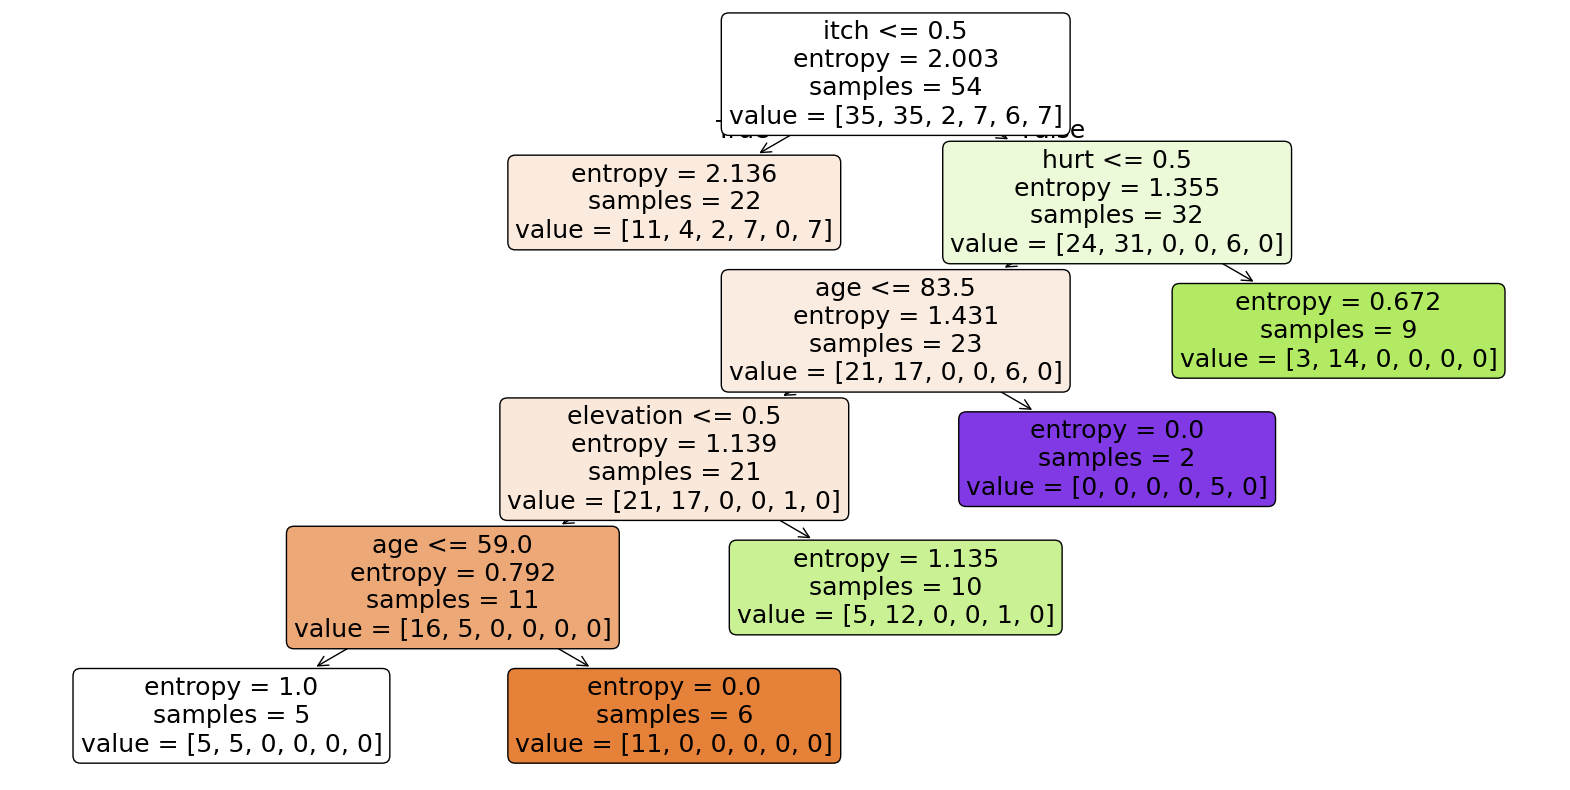

In [ ]:
# Tree graph to interpret the predictions
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(
    rf.estimators_[0],
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    max_depth=10
)
plt.show()


In [ ]:
# Save model
dumpPATH = Path("models/random_forest_model.pkl")
joblib.dump(rf, dumpPATH)

FileNotFoundError: [Errno 2] No such file or directory: 'models\\random_forest_model.pkl'